In [ ]:
import pandas as pd
import numpy as np
import glob

from prophet.plot import plot_plotly, plot_components_plotly

import plotly.express as px

import locale
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import src.tools as tools

In [3]:
conf = {
    "SEED": 42,
    "fft" : {
        "enabled": True,
        "dt": 1.0,
        "plot_fft": False,
        "convert_period": {
            "sec2day": False,
            "hour2day": False,
            "month2day": False
        },
        "sel_freqs": { 
            "enabled": True,           
            "method": "N-Head",
            "clustering": {
                            "K": 800
            },
            "N-Head": {
                "n": 700,
            },
            "N-Tail": {
                "n": 300,
            },
            "binning": {
                "n": 200,
            },
        },      
    },
    "prophet":{
        "weekly_seasonality": False,
        "daily_seasonality": False,
        "yearly_seasonality": False,
        "interval_width": 0.80,
        "mcmc_samples": 0,
        "uncertainty_samples": 2000,        
        "changepoint_prior_scale": 0.01,        
        "changepoint_range": 0.8,
        "n_changepoints": 5,
        "extra_regressors": {
            "enabled" : False,
            "names": ['TSA', 'PDO']
        },
        "fourier_order": 5,
        "mode": "additive",
        "synthetic_time": True, #For seasonality less than 1 day
    }, 
    "verbose": 1
}
conf

{'SEED': 42,
 'fft': {'enabled': True,
  'dt': 1.0,
  'plot_fft': False,
  'convert_period': {'sec2day': False, 'hour2day': False, 'month2day': False},
  'sel_freqs': {'enabled': True,
   'method': 'N-Head',
   'clustering': {'K': 800},
   'N-Head': {'n': 700},
   'N-Tail': {'n': 300},
   'binning': {'n': 200}}},
 'prophet': {'weekly_seasonality': False,
  'daily_seasonality': False,
  'yearly_seasonality': False,
  'interval_width': 0.8,
  'mcmc_samples': 0,
  'uncertainty_samples': 2000,
  'changepoint_prior_scale': 0.01,
  'changepoint_range': 0.8,
  'n_changepoints': 5,
  'extra_regressors': {'enabled': False, 'names': ['TSA', 'PDO']},
  'fourier_order': 5,
  'mode': 'additive',
  'synthetic_time': True},
 'verbose': 1}

In [4]:
#0 -> swell
#1 -> bimodal
#2 -> multimodal
#3 -> extremo
IDX = 0

In [5]:
dt = 0.78125 #segundos

In [6]:
ddir = './dados/Waverider'
series = ['swell', 'bimodal', 'multimodal', 'extremo']

mcut = 30
dt_cut = [f'2021-06-17 00:{mcut}:00.000000', f'2021-06-20 05:{mcut}:00.000000', f'2021-06-06 03:{mcut}:00.000000', f'2021-04-21 13:{mcut}:00.000000']

In [7]:
arqs = sorted(glob.glob(f"{ddir}/{series[IDX]}/*.raw"))
arqs


['./dados/Waverider/swell/2021-06-17T00h00.raw',
 './dados/Waverider/swell/2021-06-17T00h30.raw']

In [8]:
df, t_ori = tools.read_files(arqs, dt)
df

,ds,ds_ori,y
0,1950-01-01,2021-06-17 00:00:00.000000,0.72
1,1950-01-02,2021-06-17 00:00:00.781250,0.99
2,1950-01-03,2021-06-17 00:00:01.562500,0.85
3,1950-01-04,2021-06-17 00:00:02.343750,0.03
4,1950-01-05,2021-06-17 00:00:03.125000,-0.22
...,...,...,...
4603,1962-08-09,2021-06-17 00:59:56.093750,0.26
4604,1962-08-10,2021-06-17 00:59:56.875000,0.04
4605,1962-08-11,2021-06-17 00:59:57.656250,-0.05
4606,1962-08-12,2021-06-17 00:59:58.437500,-0.01


In [9]:
fig = px.line(df, x="ds_ori", y="y", title=f"Série de Heave - {series[IDX].capitalize()}", labels={"time_sec": "Tempo (s)", "n1": "n1"})
fig.show()

In [10]:
df_trn, df_tst = tools.split_train_test(df, dt_cut[IDX])
print('Treino:')
display(df_trn)
print('Teste:')
display(df_tst)

Treino:


,ds,y
0,1950-01-01,0.72
1,1950-01-02,0.99
2,1950-01-03,0.85
3,1950-01-04,0.03
4,1950-01-05,-0.22
...,...,...
2300,1956-04-19,0.27
2301,1956-04-20,0.16
2302,1956-04-21,0.25
2303,1956-04-22,-0.05


Teste:


,ds,y
2305,1956-04-24,0.20
2306,1956-04-25,0.83
2307,1956-04-26,0.81
2308,1956-04-27,0.26
2309,1956-04-28,-0.26
...,...,...
4603,1962-08-09,0.26
4604,1962-08-10,0.04
4605,1962-08-11,-0.05
4606,1962-08-12,-0.01


In [11]:
from src.atm_timeseries.profeta import Profeta

In [12]:
prf = Profeta(conf)

In [13]:
df_trn_corr = df_trn.copy()
#df_trn_corr['y'] = df_trn['y'] * 1.1624
df_trn_corr

,ds,y
0,1950-01-01,0.72
1,1950-01-02,0.99
2,1950-01-03,0.85
3,1950-01-04,0.03
4,1950-01-05,-0.22
...,...,...
2300,1956-04-19,0.27
2301,1956-04-20,0.16
2302,1956-04-21,0.25
2303,1956-04-22,-0.05


[I] Encontrando as sazonalidades
[I] FFT
[I] Máx freqs: 384
[I] N-Head 700
[I] Criando Modelo


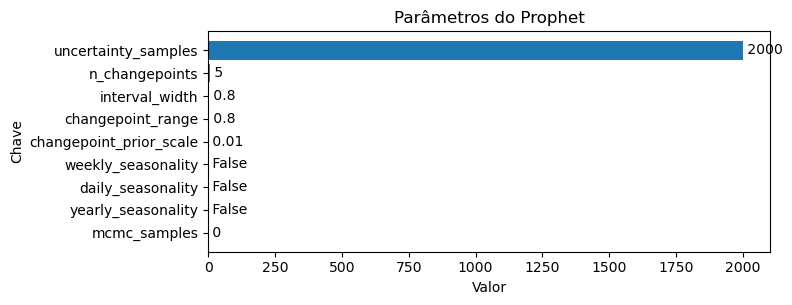

[I] Adicionando Sazonalidades
[I] Ajustando o modelo


21:33:04 - cmdstanpy - INFO - Chain [1] start processing
21:33:11 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
m = prf.fit(df_trn_corr)

In [15]:
future = df[['ds']]

In [16]:
forecast = m.predict(future)

In [17]:
#Voltando pro eixo do tempo original
forecast['ds'] = t_ori
m.history['ds'] = t_ori

In [18]:
fig = plot_plotly(m, forecast)
fig.update_layout(width=1350, height=600) 
fig.show()

In [19]:
import src.waveproc as wave

In [20]:
N = len(df_tst['y'])
print(N)
t = np.arange(N, dtype=float) * dt

2303


In [21]:
sr = df_tst['y'].values
ppt_real, _ = wave.time_domain(t, sr)
ppt_real

,hs,ts,h10,hmax,tz,thmax,hmaxhs
0,2.026867,10.447243,2.58,3.23,7.167433,15.399072,1.593592


In [22]:
ppf_real, cc_real = wave.freq_domain(t, sr, Fs=1/dt, NFFT=N/8)
ppf_real

,m0,m1,m2,m3,m4,hm0,fp,tp,tm02,tm,v,Qp,L0,k0,BFI
0,0.315921,0.039908,0.007522,0.002029,0.000696,2.253895,0.066899,14.947917,6.480585,7.916192,0.701514,2.057985,348.566732,0.018026,0.052266


In [23]:
pd.concat([ppt_real, ppf_real], axis=1)

,hs,ts,h10,hmax,tz,thmax,hmaxhs,m0,m1,m2,...,hm0,fp,tp,tm02,tm,v,Qp,L0,k0,BFI
0,2.026867,10.447243,2.58,3.23,7.167433,15.399072,1.593592,0.315921,0.039908,0.007522,...,2.253895,0.066899,14.947917,6.480585,7.916192,0.701514,2.057985,348.566732,0.018026,0.052266


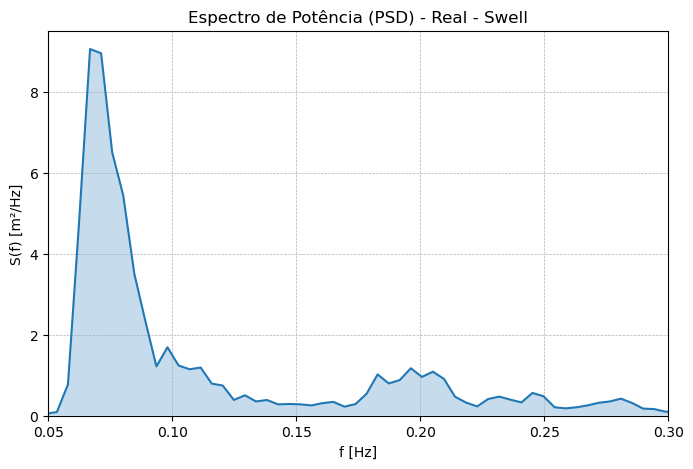

In [24]:
tools.plot_power_spectrum(
    cc_real, 
    cols="c11",
    logx=False,
    logy=False,
    xlim=(0.05, 0.3),
    units="Hz",
    density_label="S(f) [m²/Hz]", 
    title=f"Espectro de Potência (PSD) - Real - {series[IDX].capitalize()}",
    annotate_peaks=False, 
    peak_min_freq=0.05,
    fill=True, 
    fill_alpha=0.25
    )

In [25]:
sp = forecast['yhat'][-N:].values

ppt_prev, _ = wave.time_domain(t, sp)
ppt_prev

,hs,ts,h10,hmax,tz,thmax,hmaxhs
0,1.916636,10.555269,2.438143,3.308411,6.976781,13.632895,1.726155


In [26]:
ppf_prev, cc_prev = wave.freq_domain(t, sp, Fs=1/dt, NFFT=N/8)
ppf_prev

,m0,m1,m2,m3,m4,hm0,fp,tp,tm02,tm,v,Qp,L0,k0,BFI
0,0.290245,0.036299,0.006691,0.00175,0.000586,2.160361,0.066899,14.947917,6.586012,7.995865,0.688448,2.116266,348.566732,0.018026,0.051515


In [27]:
pd.concat([ppt_prev, ppf_prev], axis=1)

,hs,ts,h10,hmax,tz,thmax,hmaxhs,m0,m1,m2,...,hm0,fp,tp,tm02,tm,v,Qp,L0,k0,BFI
0,1.916636,10.555269,2.438143,3.308411,6.976781,13.632895,1.726155,0.290245,0.036299,0.006691,...,2.160361,0.066899,14.947917,6.586012,7.995865,0.688448,2.116266,348.566732,0.018026,0.051515


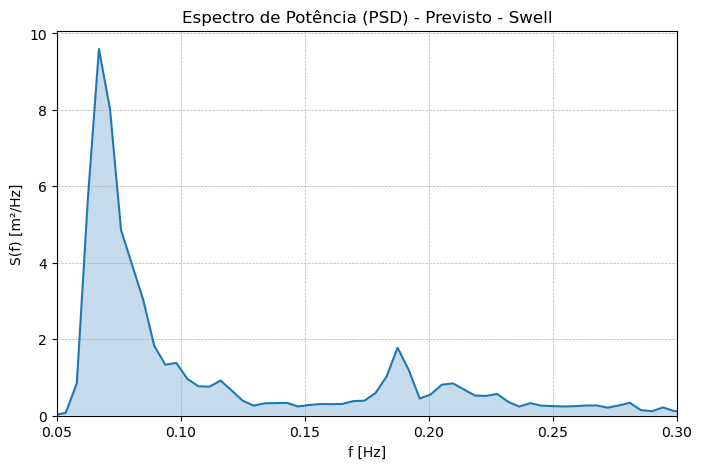

In [28]:
tools.plot_power_spectrum(
    cc_prev, 
    cols="c11",
    logx=False,
    logy=False,
    units="Hz",
    xlim=(0.05, 0.3),
    density_label="S(f) [m²/Hz]", 
    title=f"Espectro de Potência (PSD) - Previsto - {series[IDX].capitalize()}",
    annotate_peaks=False, 
    peak_min_freq=0.05,
    fill=True, 
    fill_alpha=0.25
    )

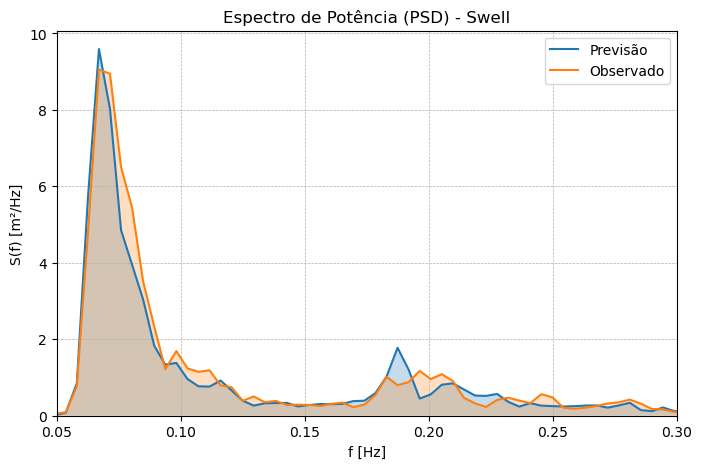

In [29]:
tools.plot_power_spectrum_pair(
    cc_prev, 
    cc_real,
    col1="c11",
    col2="c11",
    logx=False,
    logy=False,
    units="Hz",
    xlim=(0.05, 0.3),
    density_label="S(f) [m²/Hz]", 
    title=f"Espectro de Potência (PSD) - {series[IDX].capitalize()}",    
    peak_min_freq=0.05,
    fill=True, 
    fill_alpha1=0.25,
    fill_alpha2=0.25,
    label1="Previsão",
    label2="Observado"
    )